In [1]:
# %load C60_jupyter_imports.py
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import xesmf as xe
from scipy.stats import linregress
import os
import requests
import os
import scipy.signal as sps
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
# Lets import our functions. There are no tests here. Stored separately so as to not make a mess.
# Make sure in right dir first
#!pip install --user seawater==3.3.4
#import seawater

# PWD IS  /g/data/xv83/np1383/src_CAFE60_eqpac_analysis_codesrc_CAFE60_eqpac_analysis/16-transport_test.ipynb

os.chdir('/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/')
from C60_obs_functions import convert_trim_fratios
from xarray_trends import xarray_detrend,xarray_get_trend, deseasonaliser
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster

In [38]:
use_dask=True

if use_dask==True:
    # Set up the remote dask cluster. Can either use this version or a similar version above if building a LocalCluster.
    
    #cluster = SLURMCluster(cores=2,processes=1,memory="16GB")
    cluster = SLURMCluster(cores=8,processes=4,memory="22GB")#47GB")
    client = Client(cluster)
    cluster.scale(cores=16)
    #cluster.adapt(minimum=2, maximum=16)
    cluster
    #client

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.07/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38945 instead
  warnings.warn(


In [3]:
cluster

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/40253/status,
Dashboard: /proxy/40253/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.129:33817,Workers: 0
Dashboard: /proxy/40253/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Load preprocessed Data

In [5]:
# LOAD CAFE
bgc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
bgc=bgc.rename({'xt_ocean':'lon','yt_ocean':'lat'})
bgc['lon']=bgc['lon']+360
eqpac=bgc.sel(lon=slice(120,290),lat=slice(-40,40))
eqpac['time']=eqpac.time.astype('datetime64[M]')
eqpac

,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [6]:
# Load Physics
phys=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip')
phys=phys.rename({'xu_ocean':'lon_x','yu_ocean':'lat_x'})
phys=phys.rename({'xt_ocean':'lon','yt_ocean':'lat'})

phys['lon']=phys['lon']+360
phys['lon_x']=phys['lon_x']+360

phys_eqpac=phys.sel(lon=slice(120,290),lat=slice(-40,40),lon_x=slice(120,290),lat_x=slice(-40,40))

phys_eqpac['time']=phys_eqpac.time.astype('datetime64[M]')
phys_eqpac

,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,311.10 GiB,26.15 MiB
Shape,"(731, 96, 50, 140, 170)","(1, 96, 3, 140, 170)"
Count,24855 Tasks,12427 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [7]:
# I cut out ensemble 25 previously, path is '/g/data4/xv83/np1383/processed_data/physics_ds/ .... tx_trans_physics_feb7.nc

# Load Data
dic=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_pac_feb7.nc') #physics_ds
cafe_x_tx=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/tx_trans_physics_feb7.nc').tx_trans.chunk('auto')
cafe_y_tx=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/ty_trans_physics_feb7.nc').ty_trans.chunk('auto')
cafe_x_tx_gm=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/tx_trans_gm_physics_feb7.nc').tx_trans_gm.chunk('auto') # Including eddies or subscale processes?
cafe_y_tx_gm=xr.open_dataset('/g/data4/xv83/np1383/processed_data/physics_ds/ty_trans_gm_physics_feb7.nc').ty_trans_gm.chunk('auto')
# y is v and x is u directions?

adic_cafe=dic['adic'].chunk('auto')
dic_cafe=dic['dic'].chunk('auto')
anth_dic_cafe=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_DIC_pac_feb7.nc').__xarray_dataarray_variable__.chunk('auto')

adic_cafe=dic['adic']
dic_cafe=dic['dic']
anth_dic_cafe=xr.open_dataset('../processed_data/physics_ds/anth_DIC_pac_feb7.nc').__xarray_dataarray_variable__
cafe_wt=xr.open_dataset('../processed_data/physics_ds/wt_physics_feb7.nc').wt


cafe_co2=xr.open_dataset('../processed_data/physics_ds/stf10_bgc_feb7.nc').stf10
cafe_co2_natural=xr.open_dataset('../processed_data/physics_ds/stf07_bgc_feb7.nc').stf07
cafe_co2_anth=cafe_co2-cafe_co2_natural


cafe_density=xr.open_dataset('../processed_data/physics_ds/density_physics_feb7.nc').__xarray_dataarray_variable__
cafe_potential_density=xr.open_dataset('../processed_data/physics_ds/potential_density_physics_feb7.nc').__xarray_dataarray_variable__
#cafe_co2_anth


area_m2=xr.open_dataset('/g/data/xv83/rxm599/area.nc')
area_m2['xt_ocean']=area_m2['xt_ocean']+360
#area_m2['xu_ocean']=area_m2['xu_ocean']+360
area_m2=area_m2.sel(xt_ocean=slice(120,290),yt_ocean=slice(-40,40)).area_t.rename({'xt_ocean':'lon','yt_ocean':'lat'})


# Since we are calculating the below in mmol/m3/s, compared to the cafe transport calcs from CAFE which are in sverdrups 1,000,000 m3/s
upwelling_depth=-300
upwelling_cafe=cafe_wt.chunk('auto').rolling(sw_ocean=2).mean().sel(sw_ocean=upwelling_depth,method='nearest') #


upwelling=(upwelling_cafe.rename({'sw_ocean':'st_ocean'})*dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=upwelling_depth,method='nearest')*area_m2)#/1e6 # To Sverdrups (From m3?)
anthupwelling=(upwelling_cafe.rename({'sw_ocean':'st_ocean'})*anth_dic_cafe.chunk('auto').rolling(st_ocean=2).mean().sel(st_ocean=upwelling_depth,method='nearest')*area_m2)#/1e6 # To Sverdrups



anthflux=((cafe_co2_anth*-1)*area_m2)#/1e6 # Or maybe 9? # To Sverdrups (Because skin not m3? I have no idea).
flux=((cafe_co2*-1)*area_m2)#/1e6 #Or mabe 9? To Sverdrups


# 1Sv=10^6 m3 s1

In [20]:
dic_u_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_u_tx_density.nc').tracer.chunk('auto')#*1e6#.__xarray_dataarray_variable__
anth_dic_u_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_u_tx_density.nc').tracer.chunk('auto')#*1e6#.__xarray_dataarray_variable__

dic_v_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/dic_v_tx_density.nc').tracer.chunk('auto')#*1e6#.__xarray_dataarray_variable__
anth_dic_v_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_v_tx_density.nc').tracer.chunk('auto')#*1e6#.__xarray_dataarray_variable__
dic_w_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/upwelling_density.nc').tracer#.__xarray_dataarray_variable__
anth_dic_w_tx_dens=xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anthupwelling_density.nc').tracer



#dic_w_tx_dens.sel(density=25,method='nearest').mean(dim='time').plot()


### Check some of the vars to make sure they look ok

## Calculate ENSO Months

In [9]:
#anth_dic_u_tx

In [10]:
#Calculate ENSO

#Process EP, CP and Nino events.
elnino=pd.read_csv('../processed_data/indexes/el_nino_events_ch2.csv')
lanina=pd.read_csv('../processed_data/indexes/la_nina_events_ch2.csv')
ep_nino=pd.read_csv('../processed_data/indexes/ep_events_ch2.csv')
cp_nino=pd.read_csv('../processed_data/indexes/cp_events_ch2.csv')


nina=pd.DataFrame()
#nino=pd.DataFrame() @Wrapped in ep and cp... but maybe good to have own months?
ep=pd.DataFrame()
cp=pd.DataFrame()
all_dates=eqpac.sel(time=slice('1980','2020')).time#cafe_sst_mean.time

#Set to after 2000.
all_dates=all_dates.where(all_dates.time>=np.datetime64('2000-01-01')).dropna(dim='time')
all_dates=all_dates.where(all_dates.time<np.datetime64('2020-01-01')).dropna(dim='time')

def drop_df_values(df1,df2):
    df=df1[~df1.isin(df2)].dropna(how = 'all')
    return df

#for i in lanina.iterrows(): nina=nina.append(info[slice(i[1].start,i[1].end)])
for i in lanina.iterrows(): nina=nina.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in ep_nino.iterrows(): ep=ep.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in cp_nino.iterrows(): cp=cp.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))

#all_dates=chl.time
all_dates2=pd.DataFrame(all_dates.values)#[36:] #2000 - 2020
neutral=drop_df_values(drop_df_values(drop_df_values(all_dates2[0],cp[0]),ep[0]),nina[0])
#ep,cp,nino,neutral,info

cp_events=cp[0].values
ep_events=ep[0].values
nina_events=nina[0].values
neutral_events=neutral.values
#grid_multiplier_lat
#grid_multiplier_lon

In [45]:
# Function to get total above and below a certain cutoff in the maps.

def xarray_posneg_calc_sel_between_density_layers(ds,name,cutoff=0,mean=False,printer=True,mmols_to_pgYr_convert=True):
    density_layers=[1020,1030]#,1023,1025.5,1026.3
    ds1=ds
    if mmols_to_pgYr_convert==True:   
        ds=(ds*60*60*24*12*365)/1e18
    
    results=pd.DataFrame({})
    layer_results=[]
    for i in range(len(density_layers)-1):
        dens0=density_layers[i]
        dens1=density_layers[i+1]
        print(dens0)

        ds_denslayer=ds.sel(density=slice(dens0,dens1))
        pos=ds_denslayer.where(ds>cutoff)
        neg=ds_denslayer.where(ds<-cutoff)

        if mean==True:
            res=[pos.mean().values,neg.mean().values]
            tot=ds_denslayer.mean().values
        elif mean==False:
            res=[pos.sum().values,neg.sum().values]
            tot=ds_denslayer.sum().values
        if printer==True:
            print(np.array(res))
            print(ds1.where(ds1>0).mean().values)
        
        results=results.append(pd.DataFrame({f'{name} positive':res[0],
                                    f'{name} negative':res[1],
                                    f'{name} total':tot},index=[0]),ignore_index=True)
        
        
        pos1=ds.where(ds>cutoff)
        neg1=ds.where(ds<-cutoff)
        if mean==True:
            res1=[pos1.mean().values,neg1.mean().values]
        elif mean==False:
            res1=[pos1.sum().values,neg1.sum().values]
        print(res1)
        #layer_results.append((np.array(res).tolist()))
    print(results)
    return results

In [12]:
# Function to get total above and below a certain cutoff in the maps.

def xarray_posneg_calc(ds,cutoff=0,mean=False,printer=True,mmols_to_pgYr_convert=True):
    ds1=ds
    if mmols_to_pgYr_convert==True:   
        ds=(ds*60*60*24*12*365)/1e18 # From Seconds to Minute to Hour to Day to Year to Milligrams to Petagrams
    pos=ds.where(ds>cutoff)
    neg=ds.where(ds<-cutoff)
    if mean==True:
        res=[pos.mean().values,neg.mean().values]
    elif mean==False:
        res=[pos.sum().values,neg.sum().values]
    if printer==True:
        print(np.array(res))
        print(ds1.where(ds1>0).mean().values)
    return np.array(res)

In [13]:
#xarray_posneg_calc_sel_between_density_layers(anth_dic_v_tx_dens.sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time'))
#anth_dic_w_tx_dens.close()

In [14]:
#xr.open_dataset('/g/data/xv83/np1383/processed_data/physics_ds/anth_dic_w_tx_density.nc')

In [15]:
anth_dic_v_tx_dens

<xarray.DataArray 'tracer' (time: 731, lat: 140, lon: 170, density: 139)>
dask.array<mul, shape=(731, 140, 170, 139), dtype=float32, chunksize=(43, 70, 76, 76), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 ...
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-11-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -39.41 -38.44 -37.46 -36.47 ... 37.42 38.38 39.34
  * density   (density) float64 1.018e+03 1.018e+03 ... 1.032e+03 1.032e+03

In [16]:
dic_transport_through_box=pd.DataFrame()

# Start the Figures

### Plot 1 and 2: North and South Faces

In [46]:
client#adic_tx_n.mean(dim='time').plot()

<Client: 'tcp://10.0.128.129:45003' processes=8 threads=16, memory=40.96 GiB>

In [18]:
#anth_dic_v_tx_dens.T.mean(dim='time').plot()

1020
[ 0.5601435  -0.67908835]
223916.69
[array(0.5628248, dtype=float32), array(-0.68540484, dtype=float32)]
   Neutral Meridional DIC at 3N positive  \
0                               0.560143   

   Neutral Meridional DIC at 3N negative  Neutral Meridional DIC at 3N total  
0                              -0.679088                           -0.118945  
1020
[ 0.6352245  -0.91275495]
231997.19
[array(0.6378318, dtype=float32), array(-0.91361195, dtype=float32)]
   EP Meridional DIC at 3N positive  EP Meridional DIC at 3N negative  \
0                          0.635225                         -0.912755   

   EP Meridional DIC at 3N total  
0                       -0.27753  
1020
[ 0.6450934 -0.8591949]
253447.94
[array(0.6470278, dtype=float32), array(-0.86421835, dtype=float32)]
   CP Meridional DIC at 3N positive  CP Meridional DIC at 3N negative  \
0                          0.645093                         -0.859195   

   CP Meridional DIC at 3N total  
0                      -0.

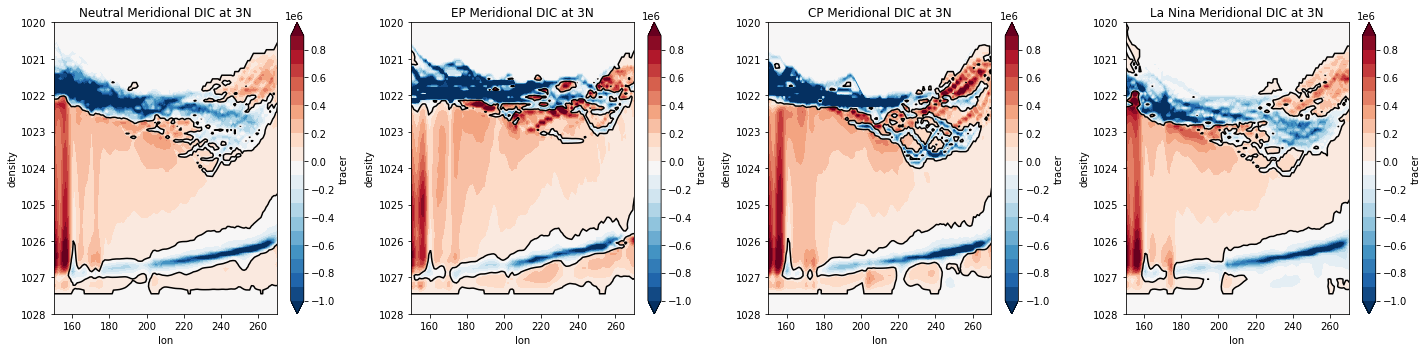

1020
[ 0.84051365 -0.5814313 ]
489943.03
[array(0.8412057, dtype=float32), array(-0.58471704, dtype=float32)]
   Neutral Meridional DIC at 3S positive  \
0                               0.840514   

   Neutral Meridional DIC at 3S negative  Neutral Meridional DIC at 3S total  
0                              -0.581431                            0.259082  
1020
[ 0.9014022 -0.6865493]
456084.53
[array(0.9021645, dtype=float32), array(-0.689082, dtype=float32)]
   EP Meridional DIC at 3S positive  EP Meridional DIC at 3S negative  \
0                          0.901402                         -0.686549   

   EP Meridional DIC at 3S total  
0                       0.214853  
1020
[ 0.9034395 -0.6382717]
512222.88
[array(0.9046583, dtype=float32), array(-0.6425655, dtype=float32)]
   CP Meridional DIC at 3S positive  CP Meridional DIC at 3S negative  \
0                           0.90344                         -0.638272   

   CP Meridional DIC at 3S total  
0                       0.26516

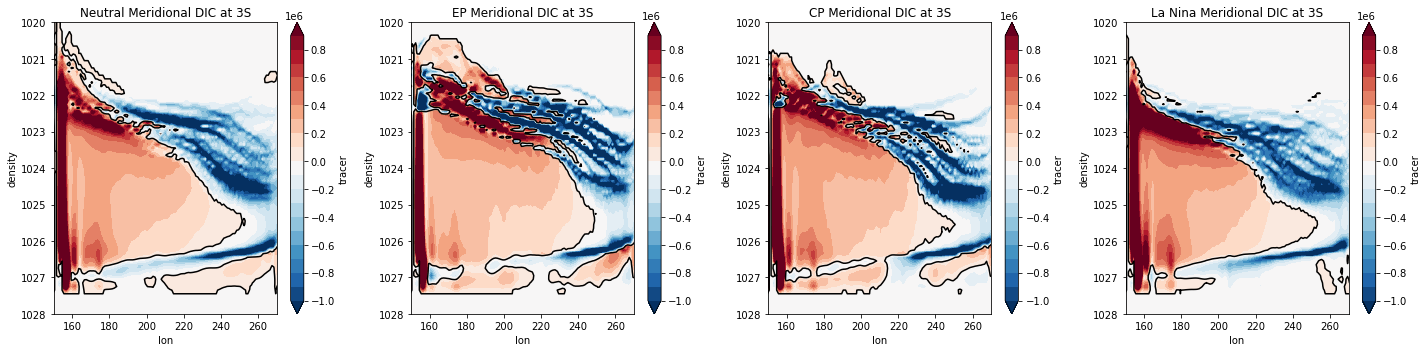

IndexError: list index out of range

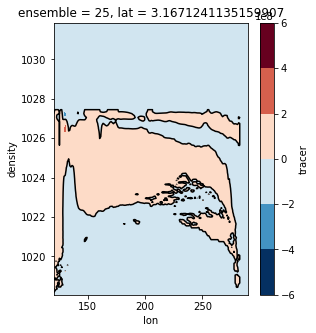

In [47]:
plot=True
if plot==True:
    N_S_data_holder=[anth_dic_v_tx_dens,dic_v_tx_dens]#anth_dic_v_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-500)),
                     #dic_v_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-500))]
                     #((grid_multiplier_lon*(anth_dic_tx_v_OLD.chunk('auto').sel(st_ocean=slice(0,-500)))/1000000).T)]

    N_S_names=['Meridional DIC']#,'Old Attempt'] #'Meridional AnthDIC'


    for i, N_S_data in enumerate(N_S_data_holder):


        for lat in [3,-3]:
            adic_tx_n=N_S_data.sel(lat=lat,method='nearest')#(grid_multiplier_lon*(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(st_ocean=slice(0,-500)))).T
            if lat==3: 
                direct='3N'
                adic_tx_n=adic_tx_n*-1  # Calculate Transport OUT of the box
            if lat==-3: direct='3S'

            plt.figure(figsize=(20,5))
            plt.subplot(141)
            if ((i==0)|(i==2)): 
                levs=np.arange(-1e6,1e6,1e5)#-1e7,1e7,1e6)
            elif i==1: 
                levs=None#np.arange(-100,120,10)#-1e7,1e7,1e6)
            #else: levs=np.arange(-10,10,1)
            contour=[0]#60,-60]

           

            plt.subplot(141)        
            adic_tx_n.sel(time=neutral_events).mean(dim='time').T.plot.contourf(levels=levs)
            adic_tx_n.sel(time=neutral_events).mean(dim='time').T.plot.contour(levels=contour,colors='k')
            asum_neutral=xarray_posneg_calc_sel_between_density_layers(adic_tx_n.sel(time=neutral_events).mean(dim='time'),name=f'Neutral {N_S_names[i]} at {direct}')
            #(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)

            ax = plt.gca()
            ax.set_ylim(ax.get_ylim()[::-1])
            
            #print(asum)
            plt.title(f'Neutral {N_S_names[i]} at {direct}')
            plt.xlim([150,270])
            plt.ylim([1028,1020])

            plt.subplot(142)
            adic_tx_n.sel(time=ep_events).mean(dim='time').T.plot.contourf(levels=levs)
            adic_tx_n.sel(time=ep_events).mean(dim='time').T.plot.contour(levels=contour,colors='k')
            asum_ep=xarray_posneg_calc_sel_between_density_layers(adic_tx_n.sel(time=ep_events).mean(dim='time'),name=f'EP {N_S_names[i]} at {direct}')
            #(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
            ax = plt.gca()
            ax.set_ylim(ax.get_ylim()[::-1])
            #print(asum)
            plt.title(f'EP {N_S_names[i]} at {direct}')
            plt.xlim([150,270])
            #plt.ylim([-300,0])
            plt.ylim([1028,1020])

            plt.subplot(143)
            adic_tx_n.sel(time=cp_events).mean(dim='time').T.plot.contourf(levels=levs)
            adic_tx_n.sel(time=cp_events).mean(dim='time').T.plot.contour(levels=contour,colors='k')
            asum_cp=xarray_posneg_calc_sel_between_density_layers(adic_tx_n.sel(time=cp_events).mean(dim='time'),name=f'CP {N_S_names[i]} at {direct}')
            #(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
            ax = plt.gca()
            ax.set_ylim(ax.get_ylim()[::-1])
            plt.title(f'CP {N_S_names[i]} at {direct}')
            plt.ylim([1028,1020])
            plt.xlim([150,270])
            #plt.ylim([-300,0])

            plt.subplot(144)
            adic_tx_n.sel(time=nina_events).mean(dim='time').T.plot.contourf(levels=levs)
            adic_tx_n.sel(time=nina_events).mean(dim='time').T.plot.contour(levels=contour,colors='k')
            asum_nina=xarray_posneg_calc_sel_between_density_layers(adic_tx_n.sel(time=nina_events).mean(dim='time'),name=f'La Nina {N_S_names[i]} at {direct}')
            #(cafe_potential_density).sel(lat=lat,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)

            ax = plt.gca()
            ax.set_ylim(ax.get_ylim()[::-1])
            plt.title(f'La Nina {N_S_names[i]} at {direct}')
            plt.xlim([150,270])
            #plt.ylim([-300,0])
            plt.ylim([1028,1020])
            plt.tight_layout()

            plt.show()
           
            #temp_holder=pd.DataFrame({'Neutral':asum_neutral,'EP':asum_ep,'CP':asum_cp,'Nina':asum_nina},index=[f'{N_S_names[i]} in {direct}',f'{N_S_names[i]} out {direct}'])
            #dic_transport_through_box=dic_transport_through_box.append(temp_holder)
            
dic_transport_through_box                                     

### Plot 3+4: Western and Eastern Faces

1020
[ 0.25188708 -0.79150206]
1287484.5
1023
[ 0.68153733 -0.81077373]
1287484.5
1025.5
[ 0.56090724 -0.42918083]
1287484.5
1026.3
[ 0.30163583 -0.3681807 ]
1287484.5
[[0.25188708305358887, -0.791502058506012], [0.6815373301506042, -0.8107737302780151], [0.560907244682312, -0.4291808307170868], [0.30163583159446716, -0.36818069219589233]]
1020
[ 0.3262985 -0.9011252]
1465194.4
1023
[ 0.7990216 -0.9889488]
1465194.4
1025.5
[ 0.5692824 -0.4537551]
1465194.4
1026.3
[ 0.32590967 -0.41956666]
1465194.4
[[0.3262985050678253, -0.9011251926422119], [0.7990216016769409, -0.9889488220214844], [0.5692824125289917, -0.45375511050224304], [0.32590967416763306, -0.41956666111946106]]
1020
[ 0.23506328 -0.9222309 ]
1388482.6
1023
[ 0.6838386 -0.8147857]
1388482.6
1025.5
[ 0.55972195 -0.42811403]
1388482.6
1026.3
[ 0.32628426 -0.36453986]
1388482.6
[[0.23506328463554382, -0.9222308993339539], [0.6838386058807373, -0.8147857189178467], [0.5597219467163086, -0.42811402678489685], [0.326284259557724, -0

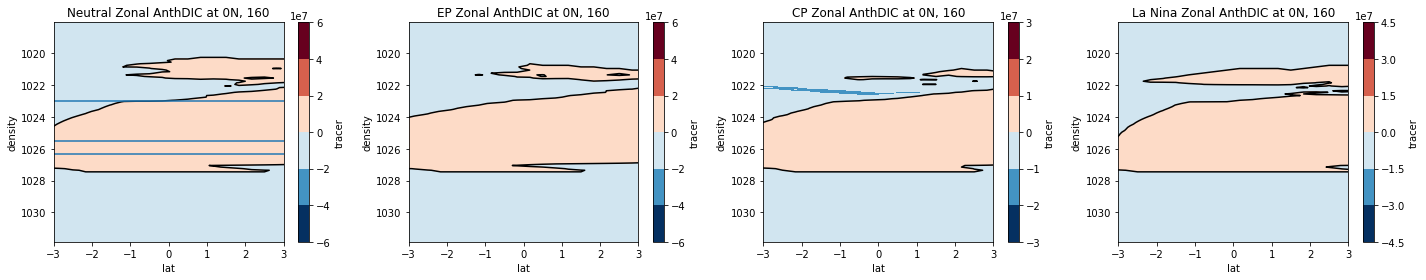

ValueError: Shape of passed values is (4, 4), indices imply (2, 4)

In [25]:
plot=True
if plot==True:

    #anth DIC
    E_W_data_holder=[anth_dic_u_tx_dens,dic_u_tx_dens]#anth_dic_u_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-500)),
                     #dic_u_tx.sel(time=slice('2000-01-01','2020-01-01')).sel(st_ocean=slice(0,-500))]
                     #((grid_multiplier_lat*(anth_dic_tx_u_OLD.chunk('auto').sel(st_ocean=slice(0,-500)))/1000000).T*-1)] # Wrong Direction

    E_W_names=['Zonal AnthDIC','Zonal DIC']#,'Zonal Old Attempt']


    for i, E_W_data in enumerate(E_W_data_holder):

        lons=[160,250]
        for lon in lons:
            if i==0 or i==2:
                levs=None#np.arange(-20,22,2)
            elif i==1:# or i==3:
                levs=None#np.arange(-1000,1100,100)
            #elif i<=4:  
            #levs=None#np.arange(-1e7,1e7,1e6)
            contour=[0]#60,-60]
            #lon=180
            lslice=slice(-3,3)


            plt.figure(figsize=(20,4))
            #plt.subplot(251)
            plt.subplot(141)

            adic_tx_b=E_W_data.sel(lon=lon,method='nearest')#.sel(st_ocean=slice(0,-500))#.T#grid_multiplier_lat.T*anth_dic_tx_u.sel(lon=lon,method='nearest').sel(lat=lslice)#.mean(dim='time')
            if lon==250:
                adic_tx_b*=-1 # Calculate Transport OUT of box. 

            #print(adic_tx_b)
            #(grid_multiplier_lon*(anth_dic_tx_v.sel(lat=lat,method='nearest').sel(st_ocean=slice(0,-500)))).T

            adic_tx_b.sel(time=neutral_events).mean(dim='time').T.plot.contourf(levels=levs)
            adic_tx_b.sel(time=neutral_events).mean(dim='time').T.plot.contour(levels=contour,colors='k')
            asum_neutral=xarray_posneg_calc_sel_between_density_layers(adic_tx_b.sel(time=neutral_events).mean(dim='time'))

            plt.axhline(1023)
            plt.axhline(1025.5)
            plt.axhline(1026.3)
            
            #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
            #print(asum)
            plt.title(f'Neutral {E_W_names[i]} at 0N, {lon}')
            #plt.xlim([150,270])
            #plt.ylim([-300,0])
            plt.xlim([-3,3])
            ax = plt.gca()
            ax.set_ylim(ax.get_ylim()[::-1])

            plt.subplot(142)
            adic_tx_b.sel(time=ep_events).mean(dim='time').T.plot.contourf(levels=levs)
            adic_tx_b.sel(time=ep_events).mean(dim='time').T.plot.contour(levels=contour,colors='k')
            asum_ep=xarray_posneg_calc_sel_between_density_layers(adic_tx_b.sel(time=ep_events).mean(dim='time'))
            #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
            #print(asum)
            plt.title(f'EP {E_W_names[i]} at 0N, {lon}')
            #plt.xlim([150,270])
            ax = plt.gca()
            ax.set_ylim(ax.get_ylim()[::-1])
            #plt.ylim([-300,0])
            plt.xlim([-3,3])

            plt.subplot(143)
            adic_tx_b.sel(time=cp_events).mean(dim='time').T.plot.contourf(levels=levs)
            adic_tx_b.sel(time=cp_events).mean(dim='time').T.plot.contour(levels=contour,colors='k')
            asum_cp=xarray_posneg_calc_sel_between_density_layers(adic_tx_b.sel(time=cp_events).mean(dim='time'))
            #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
            plt.title(f'CP {E_W_names[i]} at 0N, {lon}')
            #plt.xlim([150,270])
            ax = plt.gca()
            ax.set_ylim(ax.get_ylim()[::-1])
            #plt.ylim([-300,0])
            plt.xlim([-3,3])

            plt.subplot(144)
            adic_tx_b.sel(time=nina_events).mean(dim='time').T.plot.contourf(levels=levs)
            adic_tx_b.sel(time=nina_events).mean(dim='time').T.plot.contour(levels=contour,colors='k')
            asum_nina=xarray_posneg_calc_sel_between_density_layers(adic_tx_b.sel(time=nina_events).mean(dim='time'))
            #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
            plt.title(f'La Nina {E_W_names[i]} at 0N, {lon}')
            #plt.xlim([150,270])
            #plt.ylim([-300,0])
            plt.xlim([-3,3])
            ax = plt.gca()
            ax.set_ylim(ax.get_ylim()[::-1])


            plt.tight_layout()
            plt.show()
            # Mmol DIC/m2/s
            #cafe_v.sel(lat_x=-3,method='nearest').sel(time=slice('2010','2020')).mean(dim='time').plot.contourf(levels=np.arange(-0.1,0.11,0.01))
            
            temp_holder=pd.DataFrame({'Neutral':asum_neutral,'EP':asum_ep,'CP':asum_cp,'Nina':asum_nina},index=[f'{E_W_names[i]} in {lon}',f'{E_W_names[i]} out {lon}'])
            dic_transport_through_box=dic_transport_through_box.append(temp_holder)
            #temp_holder

In [ ]:
dic_transport_through_box


### Plot 3+4: Upwelling and Outgassing (Vertical Top and Bottom Faces)
upwelling
anthupwelling
anthupwelling_OLD
upwelling_OLD

flux
anthflux
flux_OLD
anthflux_OLD

In [ ]:
dic_w_tx_dens.sel(density=23.1,method='nearest')

In [ ]:
dic_w_tx_dens.sel(density=1025,method='nearest').sel(time=neutral_events).mean(dim='time').plot()

In [ ]:
plot=True
if plot==True:

    #anth DIC
    T_B_data_holder=[dic_w_tx_dens.sel(density=1023,method='nearest'),
                     anth_dic_w_tx_dens.sel(density=1023,method='nearest'),
                     
                     dic_w_tx_dens.sel(density=1024.5,method='nearest'),
                     anth_dic_w_tx_dens.sel(density=1024.5,method='nearest'),
                     
                     dic_w_tx_dens.sel(density=1026.3, method='nearest'),
                     anth_dic_w_tx_dens.sel(density=1026.3,method='nearest'),
                     #upwelling_OLD.sel(time=slice('2000-01-01','2020-01-01')),
                     #anthupwelling_OLD.sel(time=slice('2000-01-01','2020-01-01')),
                     
                     flux.sel(time=slice('2000-01-01','2020-01-01')),
                     anthflux.sel(time=slice('2000-01-01','2020-01-01'))]#,
                     #flux_OLD.sel(time=slice('2000-01-01','2020-01-01')),
                     #anthflux_OLD.sel(time=slice('2000-01-01','2020-01-01'))]

    #T_B_names=['Upwelling','Anthropogenic Upwelling','Upwelling Old', 'Anth Upwelling Old', 'CO2 flux', 'anth CO2 flux', 'CO2 flux OLD',' anth CO2 flux OLD']
    T_B_names=['Upwelling 23','Anthropogenic Upwelling 23','Upwelling 24.5','Anthropogenic Upwelling 24.5','Upwelling 26.3','Anthropogenic Upwelling 26.3','CO2 flux', 'anth CO2 flux']


    for i, T_B_data in enumerate(T_B_data_holder):
        if i==0:
            levs=None#np.arange(-40,45,5)
        elif i==1:
            levs=None#np.arange(-2,2.2,0.2)
        
        
        else: levs=None
        plt.figure(figsize=(20,4))
        plt.subplot(141)
        lslice=slice(-3,3)
        upwelling_dat=T_B_data.sel(lat=lslice,lon=slice(150,270))

        upwelling_dat.sel(time=neutral_events).mean(dim='time').plot.contourf(levels=levs)
        upwelling_dat.sel(time=neutral_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_neutral=xarray_posneg_calc(upwelling_dat.sel(time=neutral_events).mean(dim='time'))

        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=neutral_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        #print(asum)
        plt.title(f'Neutral {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])

        plt.subplot(142)
        upwelling_dat.sel(time=ep_events).mean(dim='time').plot.contourf(levels=levs)
        upwelling_dat.sel(time=ep_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_ep=xarray_posneg_calc(upwelling_dat.sel(time=ep_events).mean(dim='time'))
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=ep_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        #print(asum)
        plt.title(f'EP {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])

        plt.subplot(143)
        upwelling_dat.sel(time=cp_events).mean(dim='time').plot.contourf(levels=levs)
        upwelling_dat.sel(time=cp_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_cp=xarray_posneg_calc(upwelling_dat.sel(time=cp_events).mean(dim='time'))
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=cp_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        plt.title(f'CP {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])

        plt.subplot(144)
        upwelling_dat.sel(time=nina_events).mean(dim='time').plot.contourf(levels=levs)
        upwelling_dat.sel(time=nina_events).mean(dim='time').plot.contour(levels=contour,colors='k')
        asum_nina=xarray_posneg_calc(upwelling_dat.sel(time=nina_events).mean(dim='time'))
        #(cafe_potential_density).sel(lon=lon,method='nearest').sel(time=nina_events).mean(dim='time').plot.contour(levels=[1023,1024.5,1026.3],colors='gray',linestyles=":",linewidths=3)
        plt.title(f'Nina {T_B_names[i]}') 
        #plt.xlim([150,270])
        plt.xlim([150,270])
        plt.ylim([-3,3])


        plt.tight_layout()
        plt.show()
         
        temp_holder=pd.DataFrame({'Neutral':asum_neutral,'EP':asum_ep,'CP':asum_cp,'Nina':asum_nina},index=[f'{T_B_names[i]} out',f'{T_B_names[i]} in'])
        dic_transport_through_box=dic_transport_through_box.append(temp_holder)

In [ ]:
dic_transport_through_box#=dic_transport_through_box[:-8]

In [ ]:
dic_transport_through_box.to_csv('dic_tx.csv')

## End Box Estimate

In [ ]:
dic_transport_through_box

In [ ]:
((dic_transport_through_box)*44*60*60*24*365)/1e9
#1000gC/yr
#1kgC/yr
#1 000 000 mg/s * 60*60*24*365

# 

In [ ]:
#dic_tx_pgC

In [ ]:
#dic_tx_pgC.iloc[-4:]

In [ ]:
dic_transport_through_box=pd.read_csv('dic_tx.csv',index_col=0)
dic_tx_pgC=((dic_transport_through_box)*12*60*60*24*365)/1e9 #
dic_tx_pgC.iloc[-4:]=dic_tx_pgC.iloc[-4:]*-1 # Co2 Flux Directions are wrong way around.

# Units are 1e9 mmoles/s
# Pretty sure this is Petagrams. is 15 and 50PG seem correct for meridional and zonal transport of C / yr? Outgassing is like 1, so probably?
# 12 (molC to gC) * seconds *minutes* hours*days / 1e9 (rather than 1e15 since we are in 1,000,000 kg/yr not g. 
#Rather than 1e15 # Because its already in 1,000,000kg/s ??


names=dic_tx_pgC.index

old_tx=dic_tx_pgC[names.str.lower().str.contains('old')]
old_tx_anth=old_tx[old_tx.index.str.lower().str.contains('anth')]
for anth in old_tx_anth.index:
    if anth in old_tx.index:
        old_tx=old_tx.drop(anth)
        
new_tx=dic_tx_pgC[~names.str.lower().str.contains('old')]
new_tx_anth=new_tx[new_tx.index.str.lower().str.contains('anth')]
for anth in new_tx_anth.index:
    if anth in new_tx.index:
        new_tx=new_tx.drop(anth)

In [ ]:
plt.figure(figsize=(20,5))
ax=plt.subplot(111)
abs(new_tx).round(3).plot.bar(ax=ax)
for container in ax.containers:
    ax.bar_label(container,rotation=90,label_type='edge',padding=4)
#plt.ylim([0,4])
plt.legend(fontsize=14)

In [ ]:
plt.figure(figsize=(20,5))
ax=plt.subplot(111)
abs(new_tx_anth).round(3).plot.bar(ax=ax)
for container in ax.containers:
    ax.bar_label(container,rotation=90,label_type='edge',padding=4)
plt.ylim([0,4])
plt.legend(fontsize=14)

In [ ]:
# SORT BY EACH FACE

face_data=[new_tx,new_tx_anth]

box_faces=['3s','3n','160','250','upwelling','flux']


for i,df in enumerate(face_data):
    
    box_res=pd.DataFrame()
    for face in box_faces:
        result=df[df.index.str.lower().str.contains(face)]
        #print(result)
        result1=result.mean()
        result1.name=face
        #print(result.mean())
        box_res=box_res.append(result1)
        #print(result)
    if i==0:
        print('Total DIC transport')
    elif i==1:
        print('Anth DIC transport')
    box_res.plot.bar()
    plt.axhline(0,c='k')
    plt.show()
    print(box_res)
    
    print(box_res.mean())
    box_res.mean().plot.bar()
    plt.axhline(0,c='k')
    plt.show()

In [ ]:
# SORT BY IN AND OUT
# Calculate Total In / Out transport
face_data=[new_tx,new_tx_anth]
box_faces=[' in',' out']
for a,df in enumerate(face_data):
    box_res=pd.DataFrame()
    for i,face in enumerate(box_faces):
        
        direction=df[df.index.str.lower().str.contains(face)]
        result2=direction.mean()
        result2.name=str(face[1:])
        box_res=box_res.append(result2)
        #print(direction)
    if a==0:
        print(f'Total DIC transport {face}')
    elif a==1:
        print(f'Anth DIC transport {face}')
    print(box_res)
    print(box_res.mean())
#        print(box_res.mean())

In [ ]:
# Richards Depth Grid Calculation

docn=phys
mdepth=docn.st_ocean.copy()
dbot=np.copy(docn.sw_ocean)
dthick=dbot*0
dthick[1:50]=dbot[1:50]-dbot[0:49]

dthick[0]=dbot[0]
print(dthick,dbot)
mdepth=mdepth*0+dthick
mdepth